In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import pandas as pd
import numpy as np
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# define hyperparameters
input_size = 200
num_classes = 3
num_epochs = 20
batch_size = 32
learning_rate = 0.01

In [4]:
data_dir = 'PRS_RemBG'
# Define transforms
transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% horizontal flip
    transforms.RandomVerticalFlip(p=0.5), # 50% vertical flip
    transforms.RandomGrayscale(p=1), # 100% convert to gray
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

/var/folders/xw/69_8f8hs7jq2dv5d50f4nq_m0000gn/T/ipykernel_40798/3724072155.py:11: RuntimeWarning: invalid value encountered in divide
  scaled_data = (image - data_min) / (data_max - data_min)
/Users/zhiyichen/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


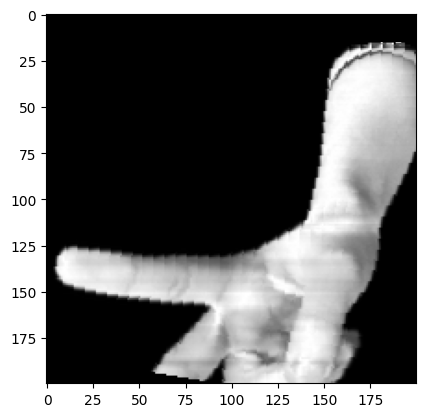

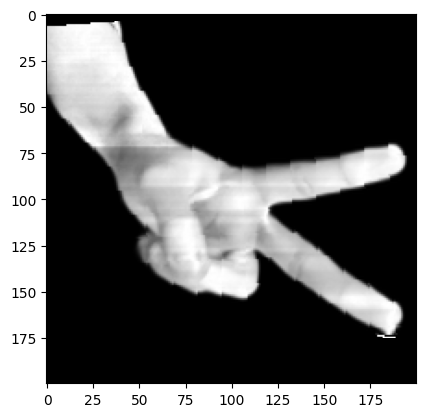

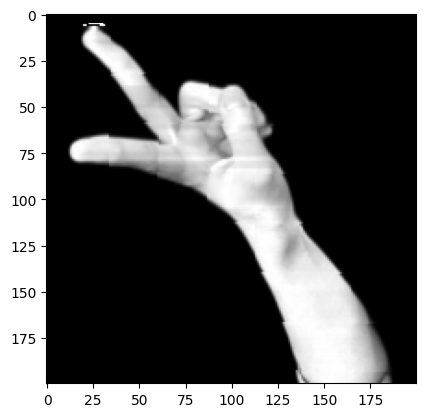

In [5]:
count = 0
for batch in train_loader:
    inputs, targets = batch
    for img in inputs:
        image  = img.cpu().numpy()
        image = image.T

        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        
        scaled_data = (image - data_min) / (data_max - data_min)
        
        plt.imshow(scaled_data)
        plt.show()
        count+=1
        if (count == 3):
          break
    if (count == 3):
          break

In [6]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # Adjust the dimensions if the input/output channels or stride changes
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [7]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self.make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self.make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self.make_layer(256, 512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
# Create ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(num_classes=len(train_dataset.classes)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [9]:
model = torch.load('remBG.mdl', map_location=torch.device('cpu'))

In [9]:
# Evaluation

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy*100:.2f} %")


Accuracy on test set: 100.00 %


2024-03-13 17:24:41.387020 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300


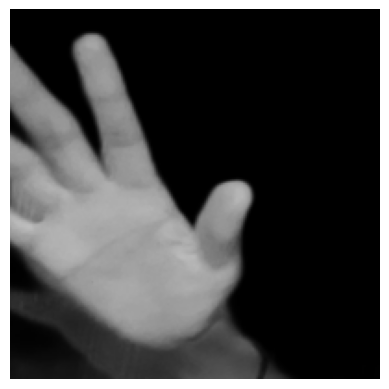

Predicted class: paper


2024-03-13 17:25:05.701587 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300


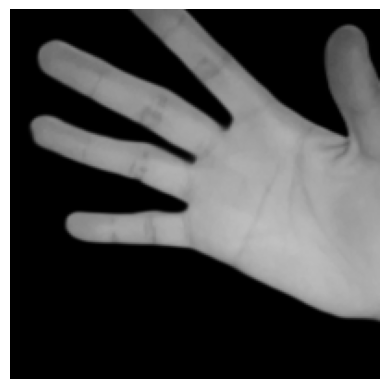

Predicted class: paper


2024-03-13 17:25:28.137487 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300


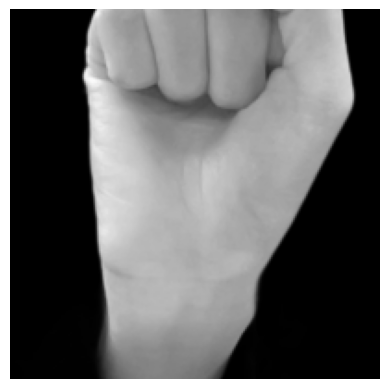

Predicted class: rock


2024-03-13 17:25:51.413876 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300


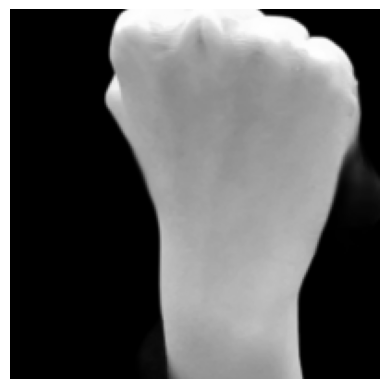

Predicted class: rock


2024-03-13 17:26:13.910521 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300


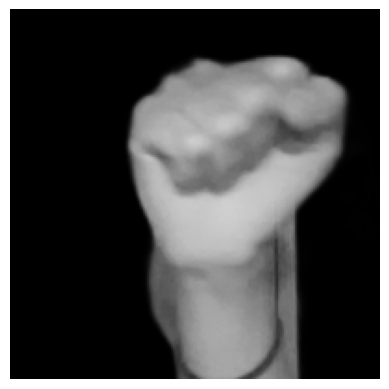

Predicted class: rock


In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from rembg import remove 

labels_dict = {0: 'paper', 1: 'rock', 2: 'scissors'}
# Load  pre-trained model
model = torch.load('remBG.mdl', map_location=torch.device('cpu'))

model.eval()  # Set the model to evaluation mode

# Define the transformations to be applied to the inputs
transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop((input_size, input_size)),
    transforms.RandomGrayscale(p=1), 
    transforms.ToTensor()
])

for i in range(5):
    image_path = 'testcases/' + str(i) + '.png'

    image = Image.open(image_path)
    image = remove(image)
    image = image.convert('RGB')

    # Apply transformations to the image
    input_array = transform(image)
    input_tensor = input_array.unsqueeze(0)  # Add batch dimension

    # Make predictions using the model
    with torch.no_grad():
        output = model(input_tensor)

    input_array = input_array.permute(1, 2, 0).numpy() 

    plt.imshow(input_array)
    plt.axis('off') 
    plt.show()

    predicted_class = torch.argmax(output).item()
    print("Predicted class:", labels_dict[predicted_class])
